In [262]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [263]:
pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [264]:
import re
import demoji
import emoji
import warnings
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import date
from collections import OrderedDict

from bs4 import BeautifulSoup

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [265]:
df_tweets = pd.read_csv("gdrive/My Drive/BT4012/project/others_dataset.csv")

In [266]:
df_tweets

,id,name,username,created_at,verified,location,description,followers_count,following_count,tweet_count,account_type,url
0,7.870000e+17,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,# @_123 @hello @567hello,1997,5,17090,bot,https://t.co/FpAstfF67l
1,7.870000e+17,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,#123 #abc #_hello,1997,5,17090,bot,https://t.co/FpAstfF67l
2,7.870000e+17,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/FpAstfF67l
3,7.870000e+17,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/pw6xYLUph5
4,7.870000e+17,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/XYsPhTkcDX
...,...,...,...,...,...,...,...,...,...,...,...,...
88129,5.241212e+08,차학연 VIXX_N,CHA_NNNNN,2012-03-14T07:48:21.000Z,True,별빛이 있는 곳,NaN,803247,7,3159,human,https://t.co/kfFSga83RW
88130,5.241212e+08,차학연 VIXX_N,CHA_NNNNN,2012-03-14T07:48:21.000Z,True,별빛이 있는 곳,NaN,803247,7,3159,human,https://t.co/VS3mHXkZYU
88131,5.241212e+08,차학연 VIXX_N,CHA_NNNNN,2012-03-14T07:48:21.000Z,True,별빛이 있는 곳,NaN,803247,7,3159,human,https://t.co/hhfB4q2GkD
88132,5.241212e+08,차학연 VIXX_N,CHA_NNNNN,2012-03-14T07:48:21.000Z,True,별빛이 있는 곳,NaN,803247,7,3159,human,https://t.co/h5kv3eJ5Il


In [267]:
def url_text(df):
    pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)' 
    df['url'] = df["uncleaned_text"].str.extract(pattern, expand=True)
    return df

def username(df):
    special_char = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    df["un_no_of_char"] = df["username"].apply(lambda x: len(str(x)))
    df["un_special_char"] = df["username"].apply(lambda x: special_char.search(str(x)) != None)
    df["un_uppercase"] = df["username"].apply(lambda x: bool(re.match(r'\w*[A-Z]\w*', str(x))))
    return df

def name(df):
    special_char = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    df["name_no_of_char"] = df["name"].apply(lambda x: len(str(x)))
    df["name_special_char"] = df["name"].apply(lambda x: special_char.search(str(x)) != None)
    df["name_uppercase"] = df["name"].apply(lambda x: bool(re.match(r'\w*[A-Z]\w*', str(x))))
    return df

def description(df):
    #user_tags = re.compile('[@]')
    #hastags = re.compile('[#]')
    user_tags = r'\B@\w*[a-zA-Z]*\w*'
    hashtags = r'\B#\w*[a-zA-Z]+\w*'
    links = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
    df["des_no_of_usertags"] = df["description"].apply(lambda x: len(re.findall(user_tags, str(x)))) #str(x).count('@'))
    df["des_no_of_hashtags"] = df["description"].apply(lambda x: len(re.findall(hashtags, str(x)))) #str(x).count('#'))
    df["des_external_links"] = df["description"].apply(lambda x: re.findall(links, str(x)) != [])
    df["has_description"] = ~df_tweets["description"].isna() 
    return df

def location(df):
    df["location"] = ~df_tweets["location"].isna() # false = location is NaN; true = has location
    return df
  
def time(df):
  # df["created_time"] = df["created_at"].apply(lambda x : datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').date())
  # d0 = date(df["created_at"])
  # d1 = date(2022, 10, 8) # date we extracted these data 
  # delta = d1 - d0
  df["account_age_in_days"] = df["created_at"].apply(lambda x : (date(2022, 10, 8) - datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').date()).days)
  df["average_tweets_per_day"] = df["tweet_count"]/df["account_age_in_days"]
  return df

def account_type(df):
  df["isFraud"] = df["account_type"].apply(lambda x : 0 if x == 'bot' else 1)
  return df

In [268]:
df_tweets = time(df_tweets)
df_tweets = account_type(df_tweets)
df_tweets = username(df_tweets)
df_tweets = name(df_tweets)
df_tweets = description(df_tweets)
df_tweets = location(df_tweets)

In [269]:
new_df_tweets = df_tweets.drop(columns=["name", "username", "description", "url"])

In [270]:
new_df_tweets

,id,created_at,verified,location,followers_count,following_count,tweet_count,account_type,account_age_in_days,average_tweets_per_day,isFraud,un_no_of_char,un_special_char,un_uppercase,name_no_of_char,name_special_char,name_uppercase,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description
0,7.870000e+17,2016-10-15T21:32:11.000Z,False,False,1997,5,17090,bot,2184,7.825092,0,15,True,False,19,False,True,3,0,False,True
1,7.870000e+17,2016-10-15T21:32:11.000Z,False,False,1997,5,17090,bot,2184,7.825092,0,15,True,False,19,False,True,0,2,False,True
2,7.870000e+17,2016-10-15T21:32:11.000Z,False,False,1997,5,17090,bot,2184,7.825092,0,15,True,False,19,False,True,2,0,False,True
3,7.870000e+17,2016-10-15T21:32:11.000Z,False,False,1997,5,17090,bot,2184,7.825092,0,15,True,False,19,False,True,2,0,False,True
4,7.870000e+17,2016-10-15T21:32:11.000Z,False,False,1997,5,17090,bot,2184,7.825092,0,15,True,False,19,False,True,2,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88129,5.241212e+08,2012-03-14T07:48:21.000Z,True,True,803247,7,3159,human,3860,0.818394,1,9,True,True,10,True,False,0,0,False,False
88130,5.241212e+08,2012-03-14T07:48:21.000Z,True,True,803247,7,3159,human,3860,0.818394,1,9,True,True,10,True,False,0,0,False,False
88131,5.241212e+08,2012-03-14T07:48:21.000Z,True,True,803247,7,3159,human,3860,0.818394,1,9,True,True,10,True,False,0,0,False,False
88132,5.241212e+08,2012-03-14T07:48:21.000Z,True,True,803247,7,3159,human,3860,0.818394,1,9,True,True,10,True,False,0,0,False,False


In [271]:
new_df_tweets.to_csv("cleaned_others_dataset.csv", index = False)

In [272]:
# Functions to plot data distributions
def plot_multiple_histograms(data: pd.DataFrame,
                             grouped_col: str,
                             target_col: str,
                             data_labels: dict):
    # Plot
    plt.figure(figsize=(12, 10))
    title = "\n"
    labels: list = list(data_labels.keys())
    for j, i in enumerate(labels):
        x = data.loc[data[grouped_col] == i, target_col]
        mu_x = round(float(np.mean(x)), 3)
        sigma_x = round(float(np.std(x)), 3)
        ax = sns.distplot(x, color=data_labels.get(i), label=i, hist_kws=dict(alpha=.1),
                          kde_kws={'linewidth': 2})
        ax.axvline(mu_x, color=data_labels.get(i), linestyle='--')
        ax.set(xlabel=f"{target_col.title()}", ylabel='Density')
        title += f"Parameters {str(i)}: $G(\mu=$ {mu_x}, $\sigma=$ {sigma_x} \n"
        ax.set_title(target_col.title() + title)
    plt.legend(title="Account Type")
    plt.grid()
    plt.tight_layout()
    plt.show()


def plot_multiple_boxplots(data: pd.DataFrame, grouped_col: str, target_col: str,
                           palette: str = "husl"):
    plt.figure(figsize=(12, 10))

    means: dict = data.groupby([grouped_col])[target_col].mean().to_dict(OrderedDict)
    counter: int = 0

    bp = sns.boxplot(x=grouped_col, y=target_col, data=data, palette=palette, order=list(means.keys()))
    bp.set(xlabel='', ylabel=f"{target_col.title()}")
    ax = bp.axes

    for k, v in means.items():
        # every 4th line at the interval of 6 is median line
        # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
        mean = round(v, 2)
        ax.text(
            counter,
            mean,
            f'{mean}',
            ha='center',
            va='center',
            fontweight='bold',
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))
        counter += 1
    bp.figure.tight_layout()
    plt.grid()
    plt.show()


def add_labels(plot1):
  i = 0
  false_counts = []
  for p in plot1.patches:
      # plot1.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*0.5))
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy()
      plt.text(x+width/2,
              y+height*0.5,
              str(format(int(p.get_height()), ',d')),
              ha='center')
      false_counts.append(p.get_height())
      if (i == 1):
          break
      i+=1

  i = 0
  for p in plot1.patches:
      if (i > 1):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        # percentage = round(100*p.get_height()/(p.get_height()+false_counts[i-2]), 2)
        plt.text(x+width/2,
              false_counts[i-2]+(p.get_height()*0.5),
              str(format(int(p.get_height()), ',d')),
              ha='center')
        # plot1.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), false_counts[i-2]+(p.get_height()*0.5)))
      i+=1

In [273]:
palette: str = "husl"
grouped: str = "account_type"
default_value: str = "unknown"

def get_labels_colors_from_pandas_column(df: pd.DataFrame, column: str, palette: str):
    data_labels: dict = dict()
    #try:
    labels: list = df[column].unique().tolist()
    colors: list = sns.color_palette(palette, len(labels))
    data_labels: dict = dict(zip(labels, colors))
    #except Exception as e:
    #    logger.error(e)
    return data_labels

# Retrieve labels and additional parameters to plot figures
data_labels: dict = get_labels_colors_from_pandas_column(
    df=new_df_tweets, column=grouped, palette=palette)

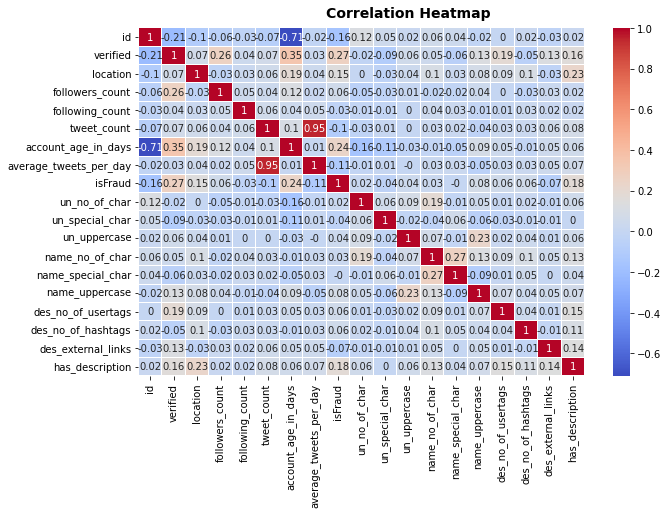

In [274]:
fig, axs = plt.subplots(1,1, figsize=(10,6))
hm = sns.heatmap(round(new_df_tweets.corr(),2), 
                 ax=axs,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 linewidths=.05)
fig.subplots_adjust(top=0.93)
t = fig.suptitle('Correlation Heatmap', fontsize=14, fontweight='bold')

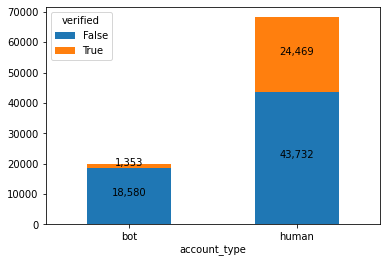

In [275]:
target_col: str = "verified"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot1 = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
add_labels(plot1)

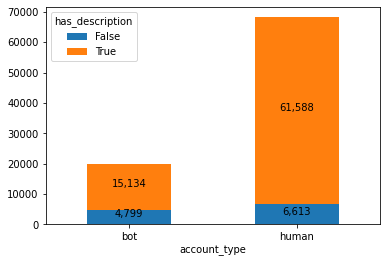

In [276]:
target_col: str = "has_description"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot2 = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0) 
add_labels(plot2)

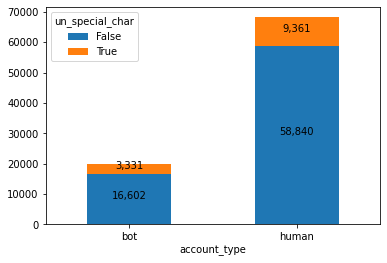

In [277]:
target_col: str = "un_special_char"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
add_labels(plot)

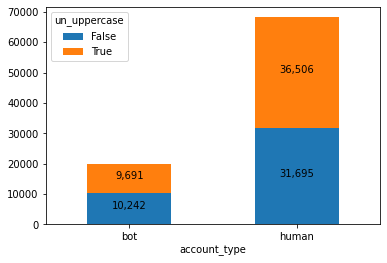

In [278]:
target_col: str = "un_uppercase"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)  
add_labels(plot)

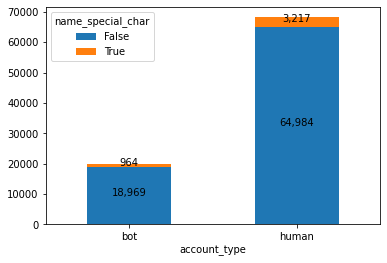

In [279]:
target_col: str = "name_special_char"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0) 
add_labels(plot)

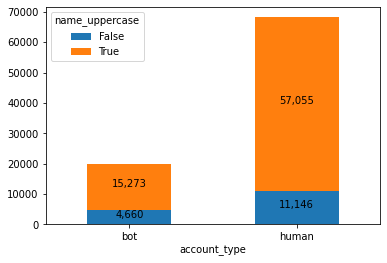

In [280]:
target_col: str = "name_uppercase"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0) 
add_labels(plot)

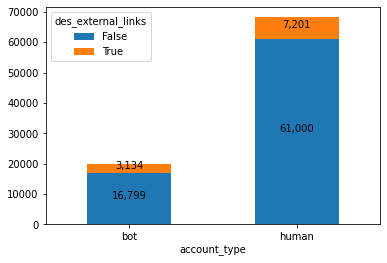

In [281]:
target_col: str = "des_external_links"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=True)
plt.xticks(rotation=0) 
add_labels(plot)

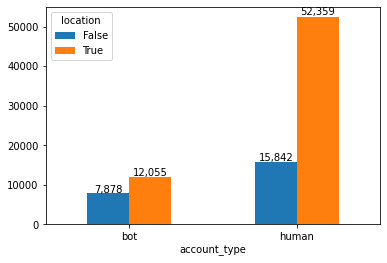

In [282]:
target_col: str = "location"
twitter_accounts_df2 = new_df_tweets.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot3 = twitter_accounts_df2.plot(kind='bar', stacked=False)
plt.xticks(rotation=0) 
# add_labels(plot3)
for p in plot3.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
            y+height*1.01,
            str(format(int(p.get_height()), ',d')),
            ha='center')

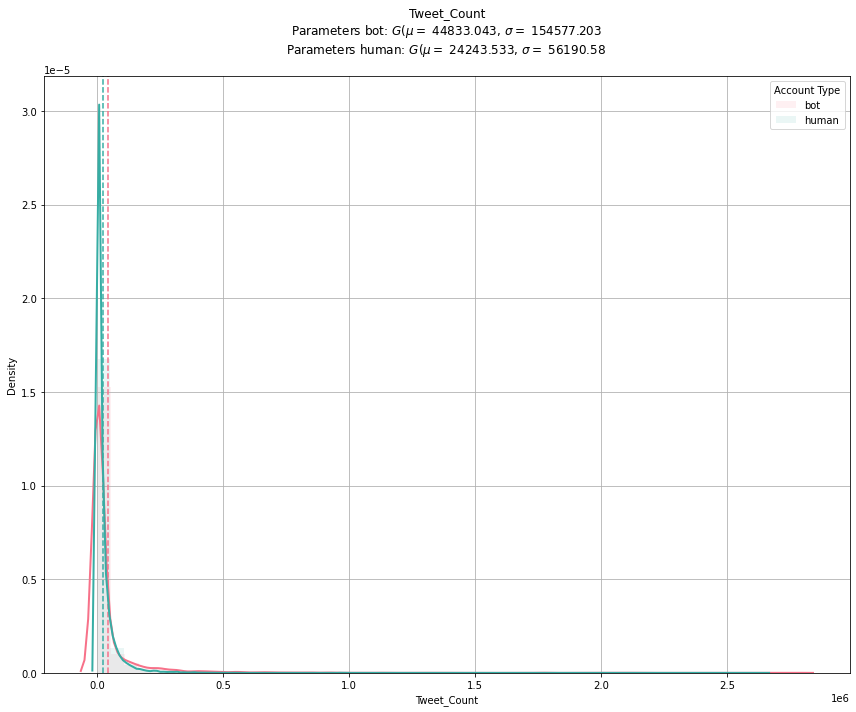

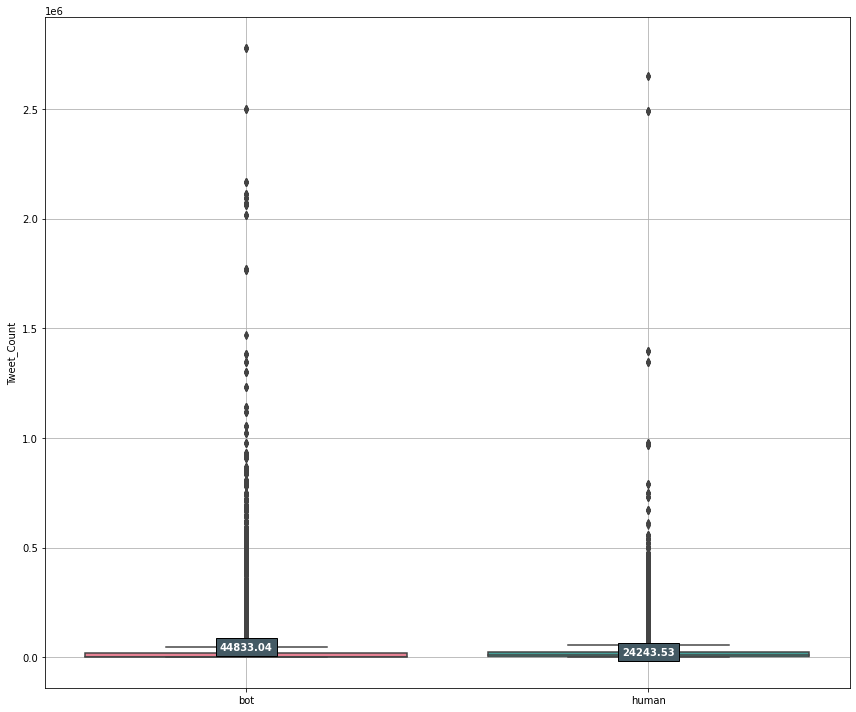

In [283]:
target: str = "tweet_count"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

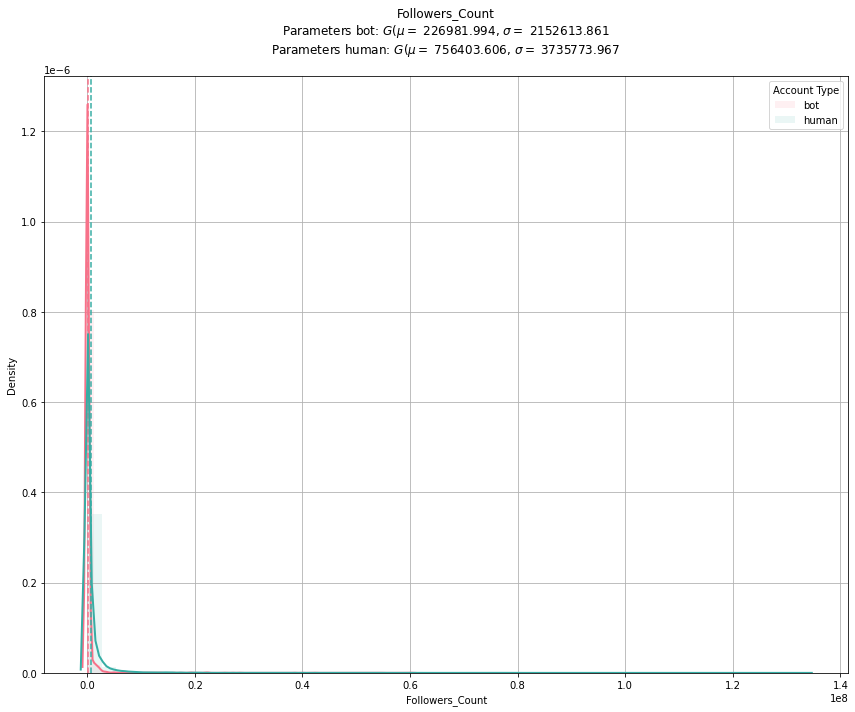

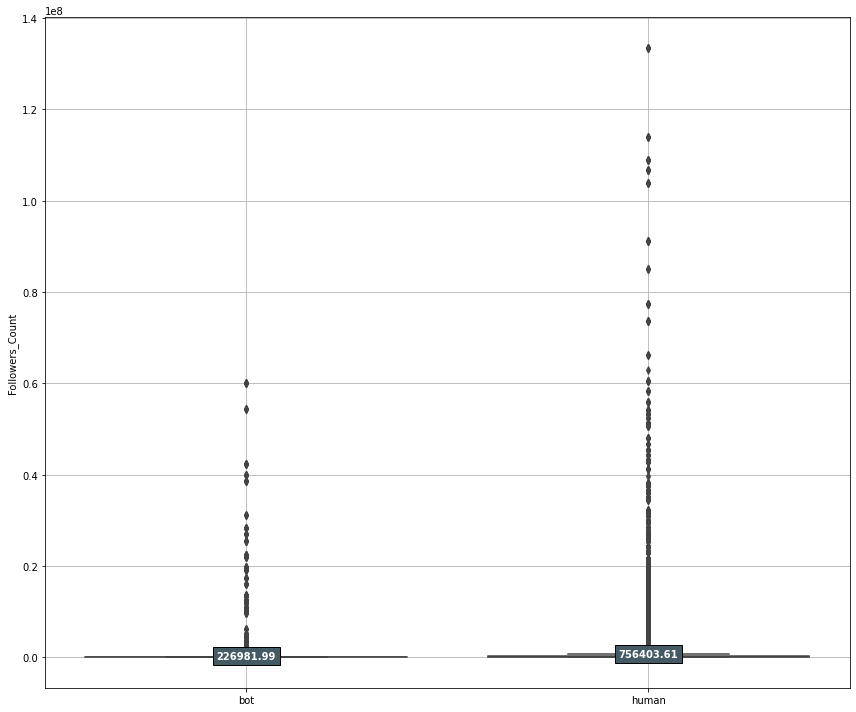

In [284]:
target: str = "followers_count"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

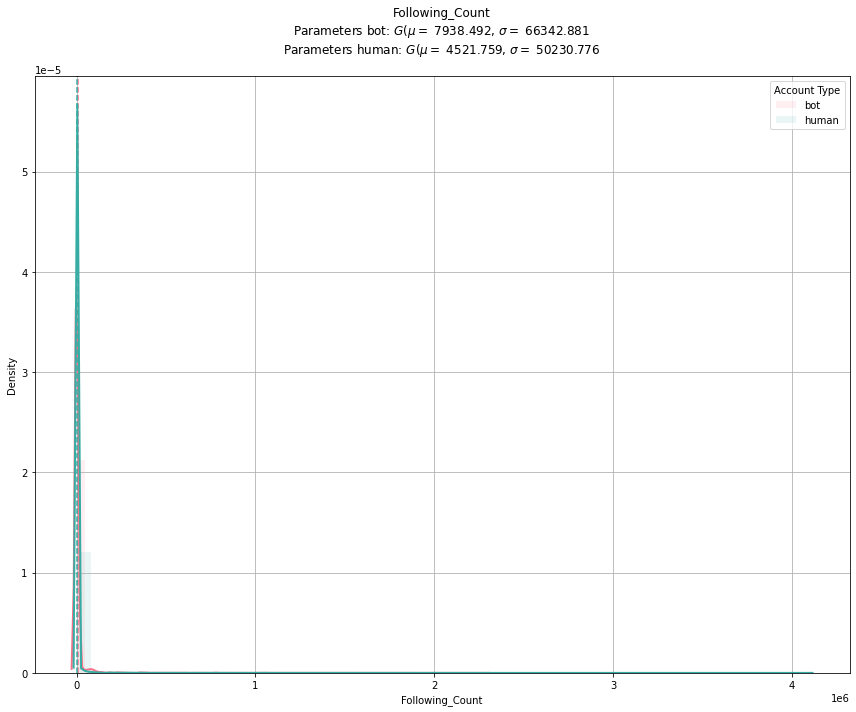

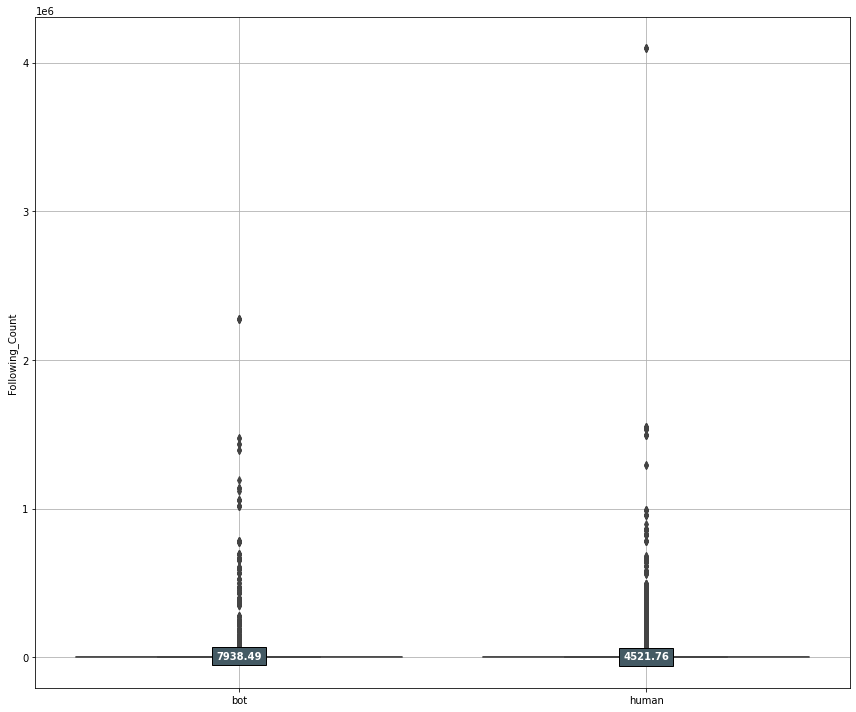

In [285]:
target: str = "following_count"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

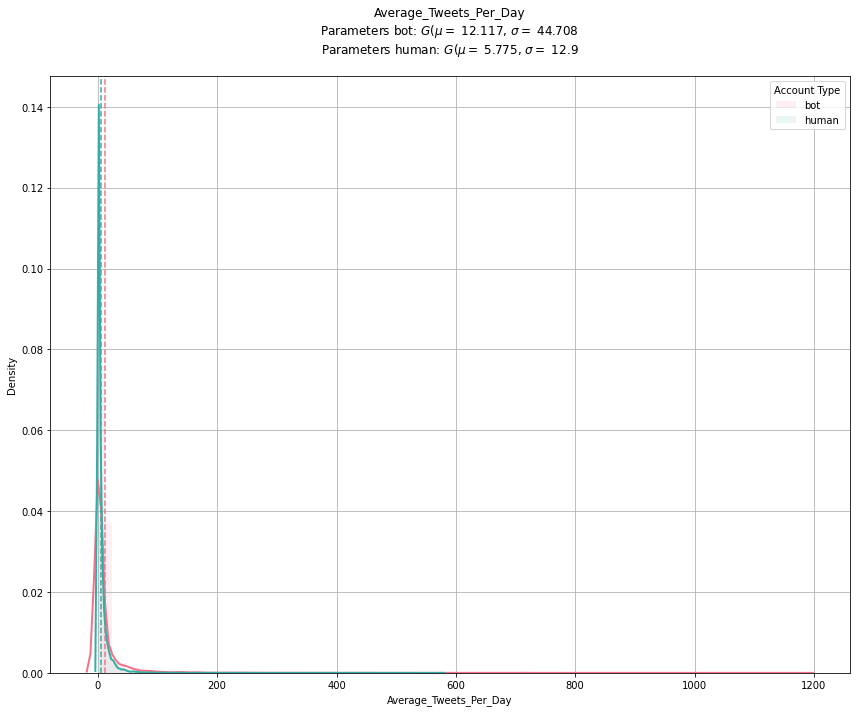

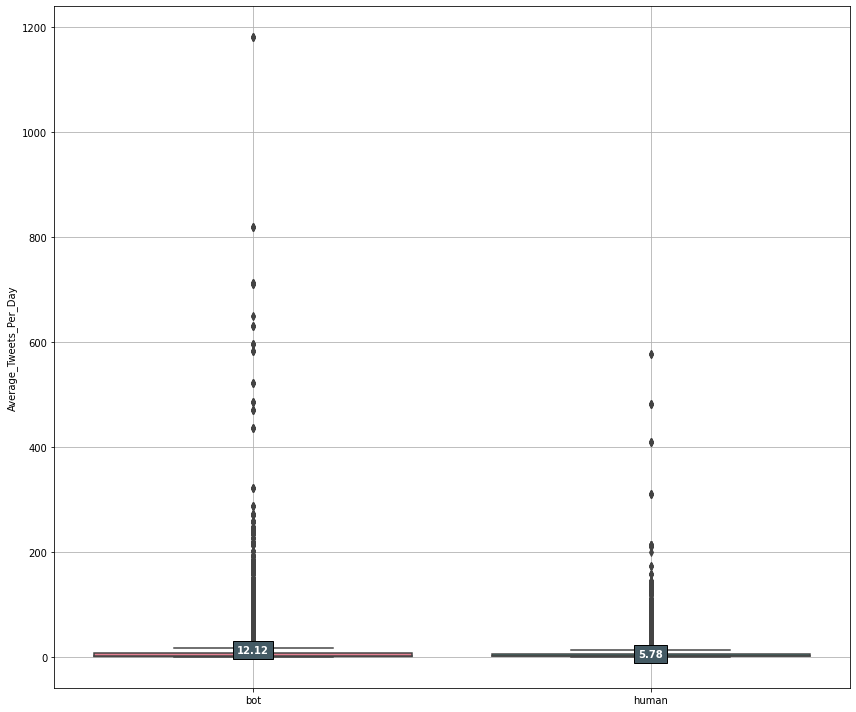

In [286]:
target: str = "average_tweets_per_day"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

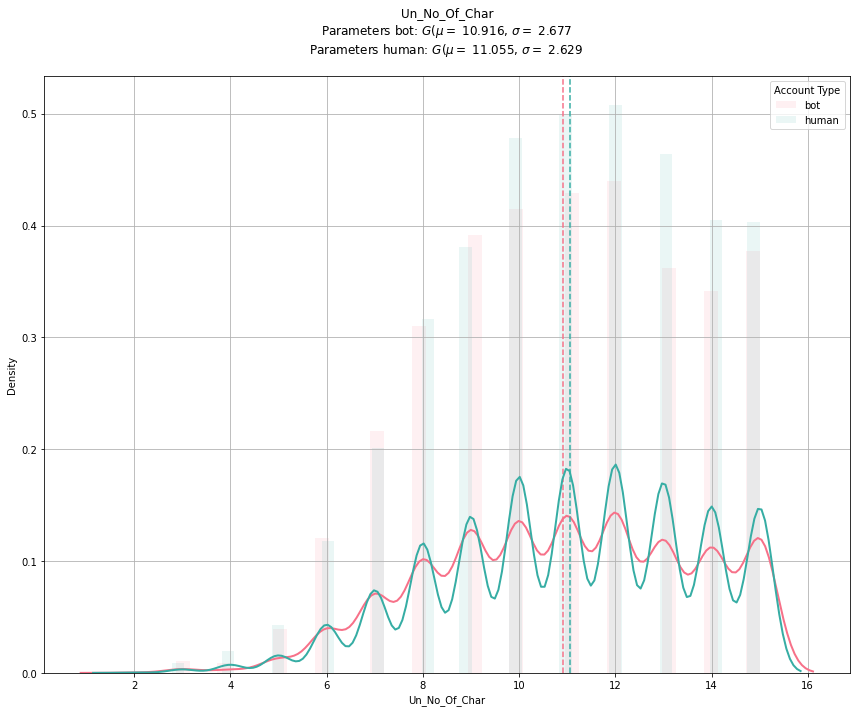

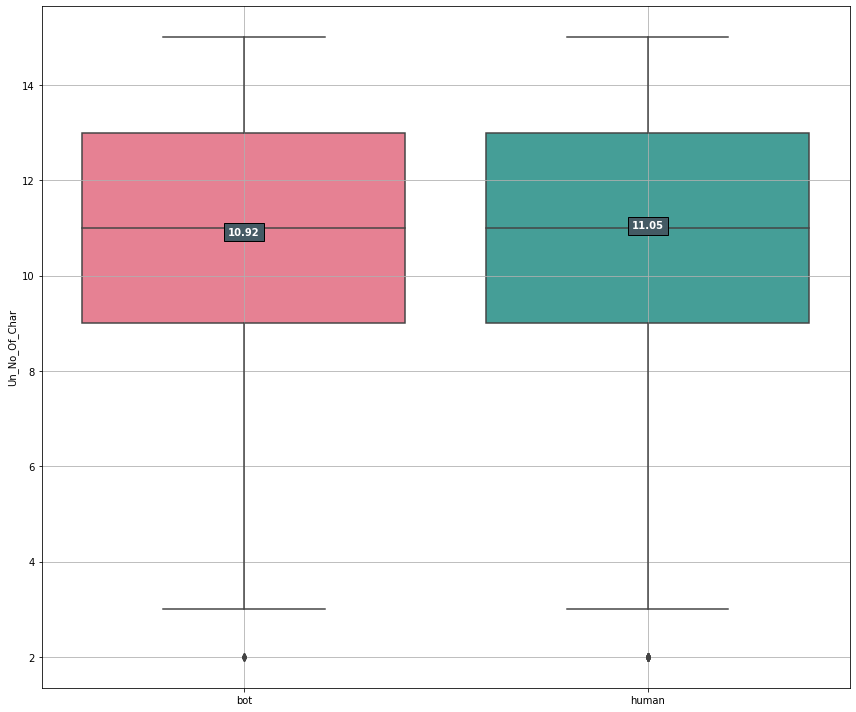

In [287]:
target: str = "un_no_of_char"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

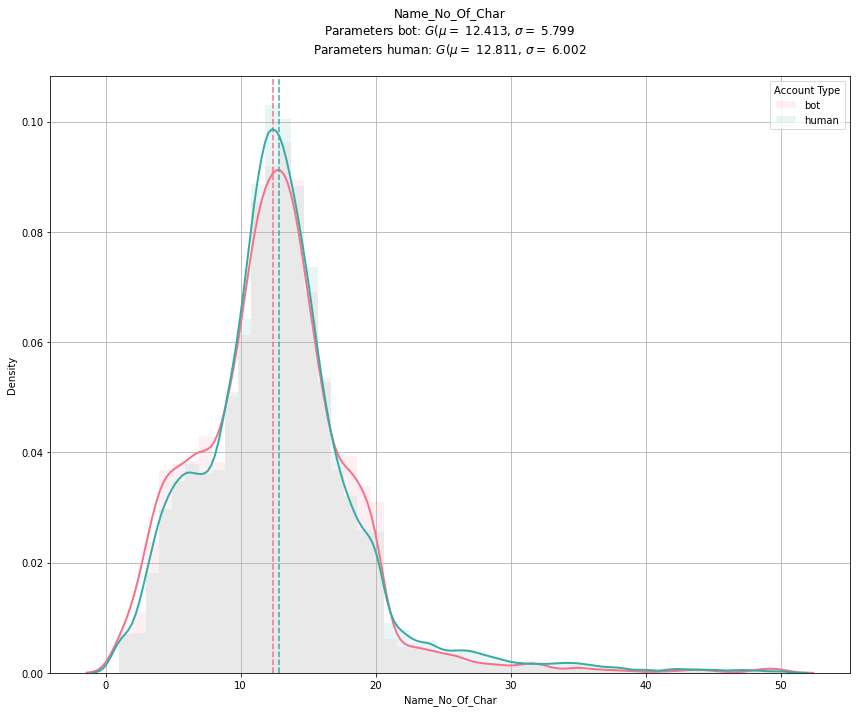

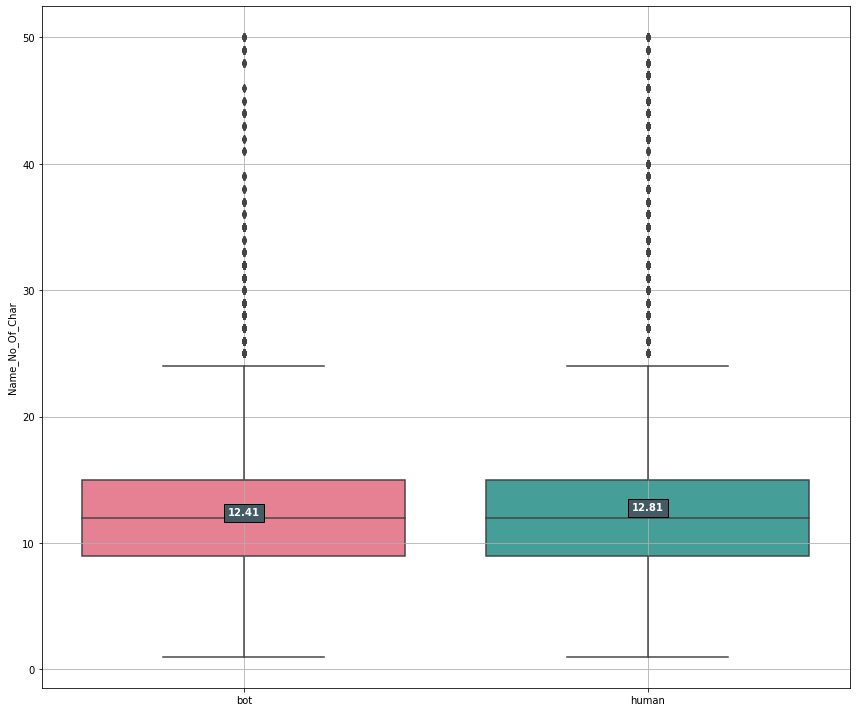

In [288]:
target: str = "name_no_of_char"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

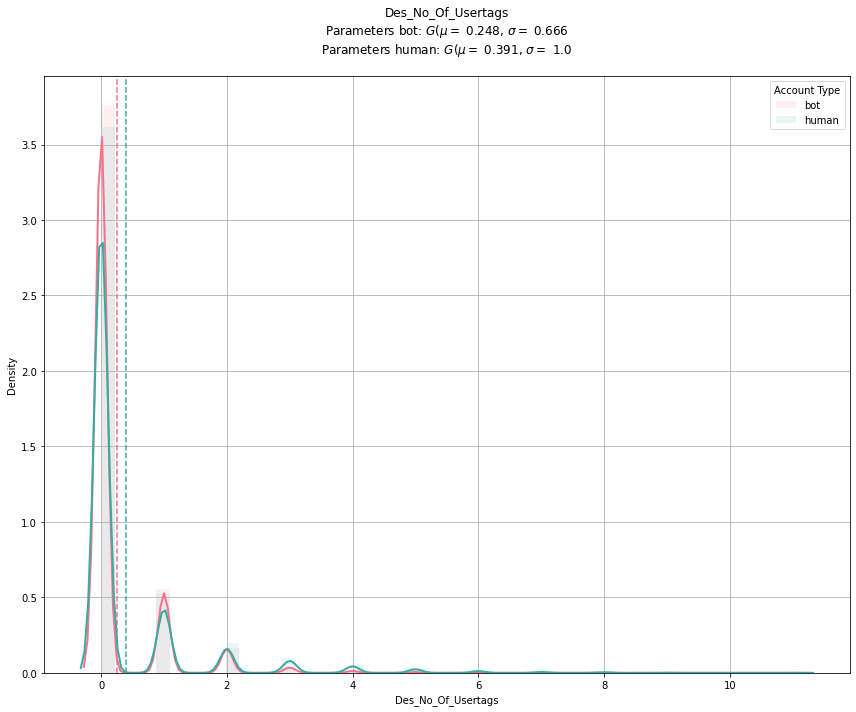

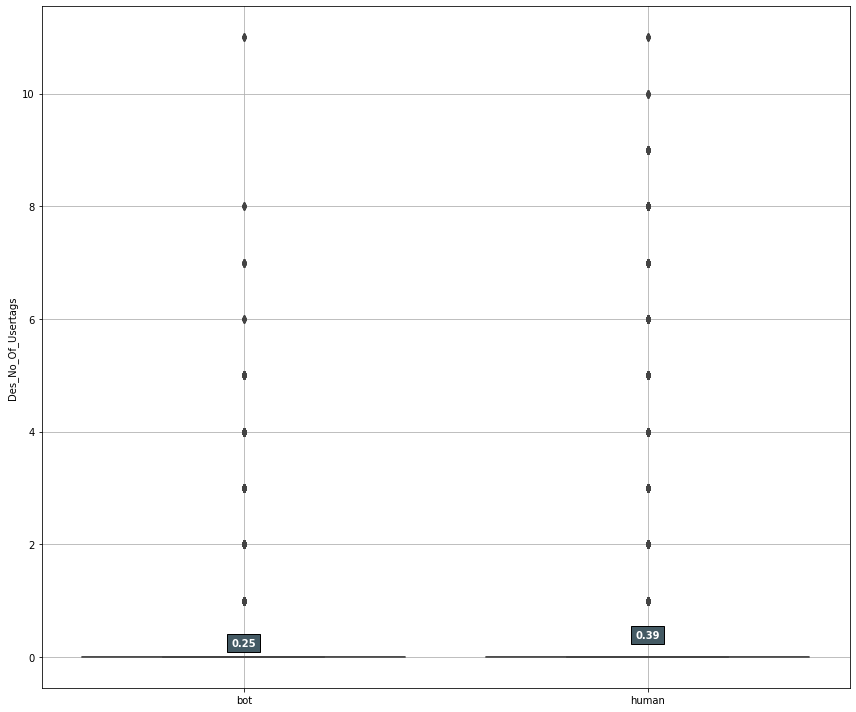

In [289]:
target: str = "des_no_of_usertags"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

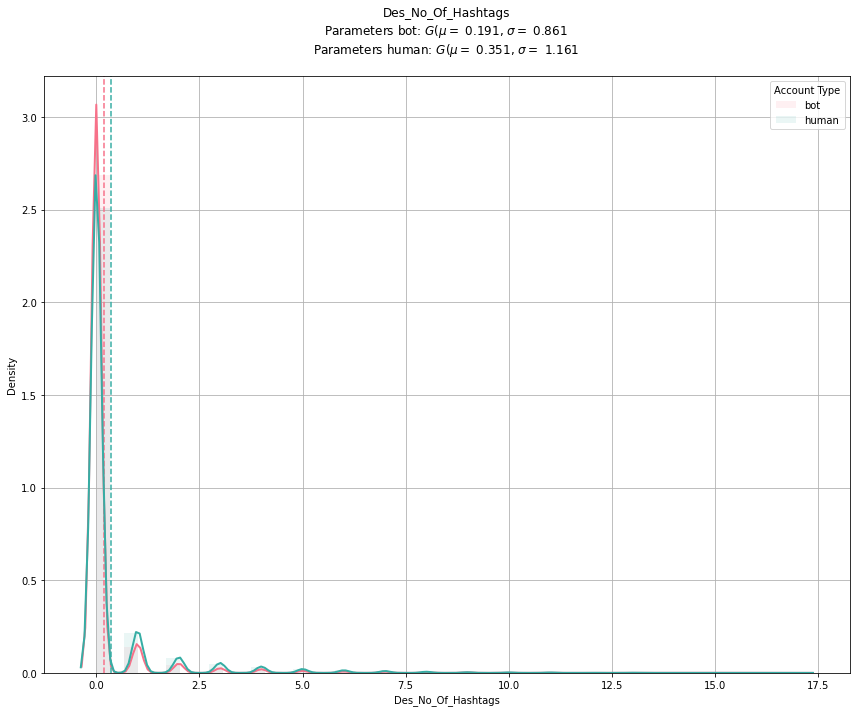

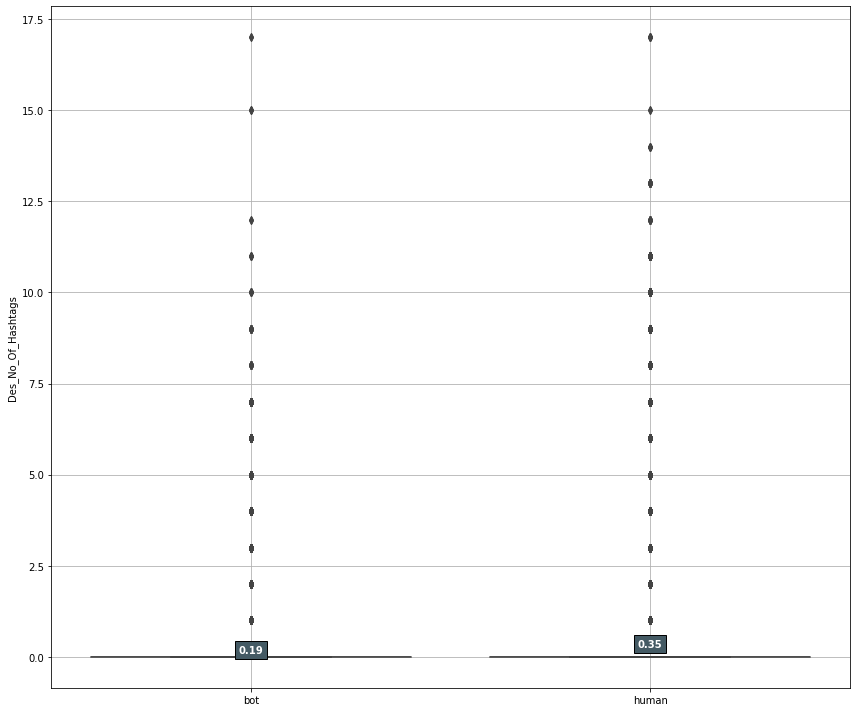

In [290]:
target: str = "des_no_of_hashtags"  
# Extract histograms
plot_multiple_histograms(data=new_df_tweets, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=new_df_tweets,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)